# ANALYSIS OF AIRFOIL GEOMETRY ON GENERATING LIFT
##### SUMMER 2024 DATA SCIENCE PROJECT
##### BY: NIKOLAI SMITH, DANNY SHI, VARSHA DEVIREDDY

## INTRODUCTION

### SOME BACKGROUND ON AERODYNAMICS AND AIRFOILS

The word "airfoil" is a fancy word for describing the cross-section of an airplane wing.

Throughout this notebook, it will be important to familiarize ourselves with
basic terminology about airplane wings and how they influence the performance of
an aircraft. The science behind the shape of airplane wings is an incredibly
complex topic with multiple sub-disciplines to explain varying phenomena
regarding fluid dynamics. We will focus on the application of potential flow
theory to incompressible, inviscid flows around airplane wings. This basically
means we're going to focus on the wings that are part of slow-flying, general-aviation planes like a Cessna-172 or a Piper Cherokee. You sometimes see some of these planes fly over UMD as they come in to land at College Park Airport


Here is an image of an airfoil and what it looks like on a wing.

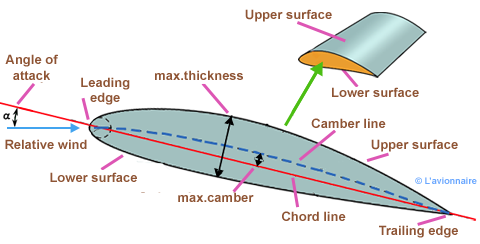

The "lift coefficient" or "lift" of an airfoil is a term that describes the
upward force generated by an airfoil under certain conditions. The lift coefficient is
a standardized dimensionless quantity for airfoils that describes how good an airfoil is at generating lift. The larger the lift coefficient, the more an airfoil generates lift. This coefficient also makes calculations regarding airfoil performance very easy and applicable to more complex problems.

The "chord line" is a line that connects the frontmost point of an airfoil (the leading edge) to the rearmost point of that airfoil (the trailing edge). In our dataset below, the chord line for all of our airfoils have been normalized to be a length of 1 meter.

The "angle of attack" or "attack angle" (commonly denoted with the greek letter, alpha) is the angle between the chord line of an airfoil and the oncoming air velocity vector. The lifting property of an airfoil is greatly affected by it's angle of attack. The influence of an attack angle is part of the reason why when an airplane takes off, it has such a steep ascent angle --
the pilot is trying to maximize the lift generated by the wings to bring the
airplane up in the sky.

The "camber line" is a line that is basically the average of the top and bottom surface. From the camber line, if you were to travel in a line perpendicular to the slope of the camber line at any point, you would have to travel the same distance to reach the top and bottom of an airfoil. "Maximum camber" refers to where the camber line is furthest from the chord line. We will refer to where the "maximum camber" point is as the "location of maximum camber".

Lastly, the "thickness" of an airfoil is just as it seems. It describes how thick the airfoil is. It is usually described as a percentage of the chord length. So, if we have an airfoil with a chord length of 1 meter, and a thickness of 10%, that means the airfoil will have a maximum thickness of 0.1 meters. If the airfoil had a chord length of 2 meters and a thickness of 15%, the macimum thickness would be 0.3 meters.

### MOTIVATION
Determining the lifting properties of an airfoil from its geometry is a field of study that has been around for several hundred years, and there is no step-by-step process to figure out the lift of an airfoil exactly. Over the years, people have developed various airfoil analysis techniques. Some are very simple, taking only a few seconds to crunch out by hand, while others are incredibly complex, taking hours for a computer solve. The ones that are simple provide okay ballpark results, while the more computationally expensive ones provide very precise results, which are typically used in characterizing an aircraft before prototyping and testing. Even then, no one method can capture all aspects of any one particular airfoil's performance.

This project aims to solve the issue of computational complexity in characterizing airfoil performance through the use of data science. For this project, we will use panel-method generated data for 2D airfoil cross sections in our analyses. The end goal of this project is to develop a model that can **quickly** and **accurately** determine aerodynamics properties of airfoils. Future research in this area would likely use combinations of various numerical methods (some more sophisticated than what we have used) and experimental data to characterize airfoils. Given the time constraints on the project, we were unable to do so. If given more time, we would likely add support for more complex airfoil geometries, incorporate other data-generation/acquisition techniques in curating our data, and cross-validate our results with various methods of airfoil characterization.


## DATA CURATION


### LOAD NECESSARY LIBRARIES

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

### LOAD DATAFRAME

We are sourcing our data from a program written by our group member, Nikolai Smith, that computes the lift coefficient of a NACA 4-digit airfoil at a given angle of attack. Supplementary information about how this program works is given at the end of this project.

In [ ]:
# Loading in our CSV as wing_data
wing_data = pd.read_csv('NACA_AIRFOIL_DATA.csv')

# Displaying the head just to verify the formatting is correct
wing_data.head(10)

AIRFOIL_CODE  ATTACK_ANGLE   KJ_LIFT  STD_LIFT  \
0            10           -14 -1.449382 -1.404309   
1            10           -12 -1.245623 -1.216653   
2            10           -10 -1.040346 -1.023069   
3            10            -8 -0.833802 -0.824501   
4            10            -6 -0.626242 -0.621917   
5            10            -4 -0.417919 -0.416302   
6            10            -2 -0.209087 -0.208659   
7            10             0  0.000000  0.000000   
8            10             2  0.209087  0.208659   
9            10             4  0.417919  0.416302   

                     MEAN_CAMBER_Y_VALS  \
0   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
1   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
2   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
3   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
4   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
5   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
6   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
7   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
8   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
9   [ 0  0  0  0  0  0  0  0  0  0  0 ]   

                                         THICKNESSES  
0  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
1  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
2  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
3  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
4  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
5  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
6  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
7  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
8  [ 0  0.039023  0.047813  0.050014  0.048358  0...  
9  [ 0  0.039023  0.047813  0.050014  0.048358  0...

So, what exactly do these columns mean? Here is a brief rundown:

AIRFOIL_CODE:\
  This column corresponds to the NACA 4-digit code of the current airfoil. The NACA code is a compact way of describing key features of an airfoil. Later in our data curation, we will extract the relevant features from this code.

ATTACK_ANGLE:\
  The ATTACK_ANGLE is just as it sounds. It is the angle of attack of the airfoil in the current entry. To reiterate as above in our introduction, the attack angle is the angle between the chord line of an airfoil and the oncoming air velocity vector.

STD_LIFT:\
  The STD_LIFT is the standard lift coefficient of the airfoil in the configuration specified by the corresponding entry in the dataframe. In theory and in experimentation, the standard lift coefficient is computed by calculating the pressure coefficient distribution over the surface of an airfoil and integrating those coefficients to get the lift coefficient.

KJ_LIFT:\
  The KJ_LIFT is the Kutta-Joukowski lift coefficient of the airfoil in the configuration specified by the corresponding entry in the dataframe. It is very similar to the standard lift coefficient, and in theory, it should be identical. Nikolai Joukowski (coincidence in names B]) and Martin Kutta were two pioneers in aerospace engineering who deduced that the lift generated by an airfoil was linearly proportional to the circulation of generated by the airfoil. So, by computing the circulation of the surrounding velocity field, you can also compute the lift of the airfoil.

MEAN_CAMBER_Y_VALS:\
  The MEAN_CAMBER_Y_VALS column describes the heigh of the mean camber at 0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of the airfoil's chord length, given as a fraction of the chord length.

THICKNESSES:\
  The THICKNESSES column describes the thickness of the airfoil at 0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of the airfoil's chord length, given as a fraction of the chord length.

### DATA CLEANING, CREATION, AND TRANSFORMATION

In [ ]:
# Let's handle duplicates and nulls by dropping them from the dataset
# Our dataset is pretty big (about 15,000 entries), so this should be okay.
wing_data.drop_duplicates()
wing_data.dropna()

AIRFOIL_CODE  ATTACK_ANGLE   KJ_LIFT  STD_LIFT  \
0                10           -14 -1.449382 -1.404309   
1                10           -12 -1.245623 -1.216653   
2                10           -10 -1.040346 -1.023069   
3                10            -8 -0.833802 -0.824501   
4                10            -6 -0.626242 -0.621917   
...             ...           ...       ...       ...   
15010          9930             6  3.301001  3.274445   
15011          9930             8  3.545295  3.502019   
15012          9930            10  3.785269  3.718707   
15013          9930            12  4.020632  3.923455   
15014          9930            14  4.251096  4.115265   

                                      MEAN_CAMBER_Y_VALS  \
0                    [ 0  0  0  0  0  0  0  0  0  0  0 ]   
1                    [ 0  0  0  0  0  0  0  0  0  0  0 ]   
2                    [ 0  0  0  0  0  0  0  0  0  0  0 ]   
3                    [ 0  0  0  0  0  0  0  0  0  0  0 ]   
4                    [ 0  0  0  0  0  0  0  0  0  0  0 ]   
...                                                  ...   
15010   [ 0  0.018889  0.035556  0.05  0.062222  0.07...   
15011   [ 0  0.018889  0.035556  0.05  0.062222  0.07...   
15012   [ 0  0.018889  0.035556  0.05  0.062222  0.07...   
15013   [ 0  0.018889  0.035556  0.05  0.062222  0.07...   
15014   [ 0  0.018889  0.035556  0.05  0.062222  0.07...   

                                             THICKNESSES  
0      [ 0  0.039023  0.047813  0.050014  0.048358  0...  
1      [ 0  0.039023  0.047813  0.050014  0.048358  0...  
2      [ 0  0.039023  0.047813  0.050014  0.048358  0...  
3      [ 0  0.039023  0.047813  0.050014  0.048358  0...  
4      [ 0  0.039023  0.047813  0.050014  0.048358  0...  
...                                                  ...  
15010  [ 0  0.11707  0.14344  0.15004  0.14508  0.132...  
15011  [ 0  0.11707  0.14344  0.15004  0.14508  0.132...  
15012  [ 0  0.11707  0.14344  0.15004  0.14508  0.132...  
15013  [ 0  0.11707  0.14344  0.15004  0.14508  0.132...  
15014  [ 0  0.11707  0.14344  0.15004  0.14508  0.132...  

[15015 rows x 6 columns]

The NACA code of an airfoil contains very important characteristics of a wing. The first digit of the code tells you the height of the maximal camber of a wing (in hundredths of the chord length), the second digit of the code tells you the chord-wise position of the maximal camber of a wing (in tenths of the chord length), and the last two digits of the code tell you the maximal percent thickness of a wing (as a percent of the chord length). An airfoil can also be identified as symmetric or asymmetric based on if whether or not the first two digits are '00'
So, let's add them as additional columns to our dataframe

In [ ]:
wing_data['MAX_CAMBER'] = wing_data['AIRFOIL_CODE'].apply(lambda x: x // 1000)
wing_data['MAX_CAMBER_LOC'] = wing_data['AIRFOIL_CODE'].apply(lambda x: (x // 100) % 10)
wing_data['MAX_PERCENT_THICKNESS'] = wing_data['AIRFOIL_CODE'].apply(lambda x: x % 100)
wing_data['IS_SYMMETRIC'] = wing_data['AIRFOIL_CODE'].apply(lambda x: True if x // 100 == 0 else False)
wing_data.head(10)

AIRFOIL_CODE  ATTACK_ANGLE   KJ_LIFT  STD_LIFT  \
0            10           -14 -1.449382 -1.404309   
1            10           -12 -1.245623 -1.216653   
2            10           -10 -1.040346 -1.023069   
3            10            -8 -0.833802 -0.824501   
4            10            -6 -0.626242 -0.621917   
5            10            -4 -0.417919 -0.416302   
6            10            -2 -0.209087 -0.208659   
7            10             0  0.000000  0.000000   
8            10             2  0.209087  0.208659   
9            10             4  0.417919  0.416302   

                     MEAN_CAMBER_Y_VALS  \
0   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
1   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
2   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
3   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
4   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
5   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
6   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
7   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
8   [ 0  0  0  0  0  0  0  0  0  0  0 ]   
9   [ 0  0  0  0  0  0  0  0  0  0  0 ]   

                                         THICKNESSES  MAX_CAMBER  \
0  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
1  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
2  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
3  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
4  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
5  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
6  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
7  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
8  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   
9  [ 0  0.039023  0.047813  0.050014  0.048358  0...           0   

   MAX_CAMBER_LOC  MAX_PERCENT_THICKNESS  IS_SYMMETRIC  
0               0                     10          True  
1               0                     10          True  
2               0                     10          True  
3               0                     10          True  
4               0                     10          True  
5               0                     10          True  
6               0                     10          True  
7               0                     10          True  
8               0                     10          True  
9               0                     10          True

The MEAN_CAMBER_Y_VALS and THICKNESSES columns of the wing_data dataframe are string. This is not good, they should be arrays so that we can properly process them. Let's fix that by converting them.

In [ ]:
# This is our helper function to perform the conversion for our particular
# strings
def string_to_float_list(string):
  string = string.rstrip()
  string = string.lstrip()
  string = string.strip('[]')
  string = string.rstrip()
  string = string.lstrip()
  arr = string.split()
  for i in range(0, len(arr)):
    arr[i] = float(arr[i])
  return arr

# Apply the conversion to the MEAN_CAMBER_Y_VALS and THICKNESSES
wing_data['MEAN_CAMBER_Y_VALS'] = wing_data['MEAN_CAMBER_Y_VALS'].apply(string_to_float_list)
wing_data['THICKNESSES'] = wing_data['THICKNESSES'].apply(string_to_float_list)

# Display the head of the dataframe just to verify that things look right.
wing_data.head(10)

AIRFOIL_CODE  ATTACK_ANGLE   KJ_LIFT  STD_LIFT  \
0            10           -14 -1.449382 -1.404309   
1            10           -12 -1.245623 -1.216653   
2            10           -10 -1.040346 -1.023069   
3            10            -8 -0.833802 -0.824501   
4            10            -6 -0.626242 -0.621917   
5            10            -4 -0.417919 -0.416302   
6            10            -2 -0.209087 -0.208659   
7            10             0  0.000000  0.000000   
8            10             2  0.209087  0.208659   
9            10             4  0.417919  0.416302   

                                  MEAN_CAMBER_Y_VALS  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         THICKNESSES  MAX_CAMBER  \
0  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
1  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
2  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
3  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
4  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
5  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
6  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
7  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
8  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   
9  [0.0, 0.039023, 0.047813, 0.050014, 0.048358, ...           0   

   MAX_CAMBER_LOC  MAX_PERCENT_THICKNESS  IS_SYMMETRIC  
0               0                     10          True  
1               0                     10          True  
2               0                     10          True  
3               0                     10          True  
4               0                     10          True  
5               0                     10          True  
6               0                     10          True  
7               0                     10          True  
8               0                     10          True  
9               0                     10          True

Now that we have MEAN_CAMBER_Y_VALS and THICKNESSES as arrays, lets convert each element in the arrays to its own cell for training our neural network later.

In [ ]:
for i in range(0, 11):
  new_camber_col = "MEAN_CAMBER_Y_VAL_" + str(i)
  wing_data[new_camber_col] = (wing_data['MEAN_CAMBER_Y_VALS'])[0][i]

for i in range(0, 11):
  new_thickness_col = "THICKNESS_" + str(i)
  wing_data[new_thickness_col] = wing_data['THICKNESSES'][0][i]

print(wing_data)


       AIRFOIL_CODE  ATTACK_ANGLE   KJ_LIFT  STD_LIFT  \
0                10           -14 -1.449382 -1.404309   
1                10           -12 -1.245623 -1.216653   
2                10           -10 -1.040346 -1.023069   
3                10            -8 -0.833802 -0.824501   
4                10            -6 -0.626242 -0.621917   
...             ...           ...       ...       ...   
15010          9930             6  3.301001  3.274445   
15011          9930             8  3.545295  3.502019   
15012          9930            10  3.785269  3.718707   
15013          9930            12  4.020632  3.923455   
15014          9930            14  4.251096  4.115265   

                                      MEAN_CAMBER_Y_VALS  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.0, 0.

Let's now delete the original array columns, as we will no longer need them. We've also extracted all the information we need from the AIRFOIL_CODE column, so let's also drop that column.

In [ ]:
wing_data = wing_data.drop(["AIRFOIL_CODE", "THICKNESSES", "MEAN_CAMBER_Y_VALS"], axis=1)

In [ ]:
# Lastly, let's verify the data types of each column. They should all be ints
# except for the lift coefficients, THICKNESSES, and MEAN_CAMBER_Y_VALS, which
# should be floats.
wing_data.dtypes

ATTACK_ANGLE               int64
KJ_LIFT                  float64
STD_LIFT                 float64
MAX_CAMBER                 int64
MAX_CAMBER_LOC             int64
MAX_PERCENT_THICKNESS      int64
IS_SYMMETRIC                bool
MEAN_CAMBER_Y_VAL_0      float64
MEAN_CAMBER_Y_VAL_1      float64
MEAN_CAMBER_Y_VAL_2      float64
MEAN_CAMBER_Y_VAL_3      float64
MEAN_CAMBER_Y_VAL_4      float64
MEAN_CAMBER_Y_VAL_5      float64
MEAN_CAMBER_Y_VAL_6      float64
MEAN_CAMBER_Y_VAL_7      float64
MEAN_CAMBER_Y_VAL_8      float64
MEAN_CAMBER_Y_VAL_9      float64
MEAN_CAMBER_Y_VAL_10     float64
THICKNESS_0              float64
THICKNESS_1              float64
THICKNESS_2              float64
THICKNESS_3              float64
THICKNESS_4              float64
THICKNESS_5              float64
THICKNESS_6              float64
THICKNESS_7              float64
THICKNESS_8              float64
THICKNESS_9              float64
THICKNESS_10             float64
dtype: object

## EXPLORATORY DATA ANALYSIS

### INVESTIGATION 1: Kutta-Joukowski Lift vs. Standard Lift

Text(0, 0.5, 'Frequency')

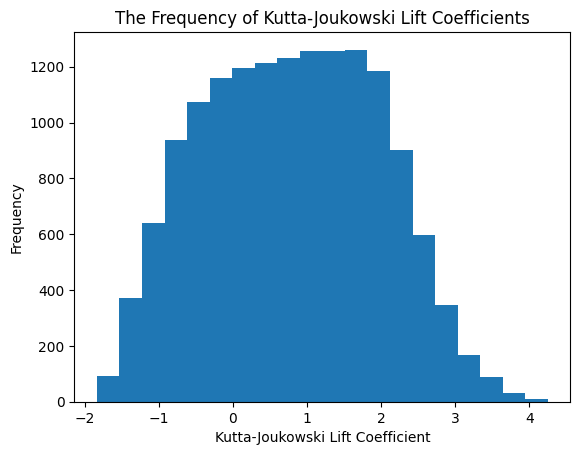

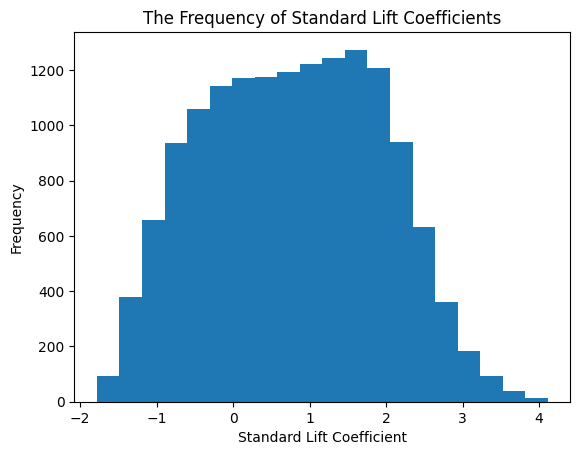

In [ ]:
# Let's look at the distribution of our data to see if it is normally distributed
plt.figure()
plt.hist(wing_data['KJ_LIFT'], bins=20)
plt.title('The Frequency of Kutta-Joukowski Lift Coefficients')
plt.xlabel('Kutta-Joukowski Lift Coefficient')
plt.ylabel('Frequency')

plt.figure()
plt.hist(wing_data['STD_LIFT'], bins=20)
plt.title('The Frequency of Standard Lift Coefficients')
plt.xlabel('Standard Lift Coefficient')
plt.ylabel('Frequency')


In [ ]:
# The dataset has two measures for lift coefficient: Kutta-Joukowski lift and
# standard lift. These are two different ways of computing the lift of an
# airplane wing from potential flow theory. Ideally, these numbers should be
# the same for each entry in the data point. From a brief look, we can see that
# they are pretty close, but not quite the same.

# Let's perform a Wilcoxon to determine if these lift coefficients
# come from the same same distribution, and are consequently the same numbers
# We use a Wilcoxon test because our data is non-normally distributed and
# The two distributions are paired

# Null Hypothesis: The standard and Kutta-Joukowski lift coefficients come from
# the same distribution
# Null Hypothesis: The standard and Kutta-Joukowski lift coefficients do not
# come from the same distribution
_, p_val_lift = sp.stats.wilcoxon(wing_data['STD_LIFT'],wing_data['KJ_LIFT'])
print('Standard and Kutta-Joukowski lift coefficient distribution analysis:')
print('Wilcoxon Test:')
print(f'\tP-value = {p_val_lift}')

Standard and Kutta-Joukowski lift coefficient distribution analysis:
Wilcoxon Test:
	P-value = 0.0


In [ ]:
# As it turns out our initial assumption that there would be of no signifcant
# difference in the lift coefficent seems to be false. As the p-value is near
# zero or zero therefore it rejects the null hypothesis. Even though the
# differences between the two lift coefficients differ by small amounts and the
# distributions appear to be almost identical, there seems to be some systematic
# bias in the underlying theory or computational approach to calculating these
# coefficients that leads to them being different

### INVESTIGATION 2: Effect of airfoil geometries on standard lift coefficient

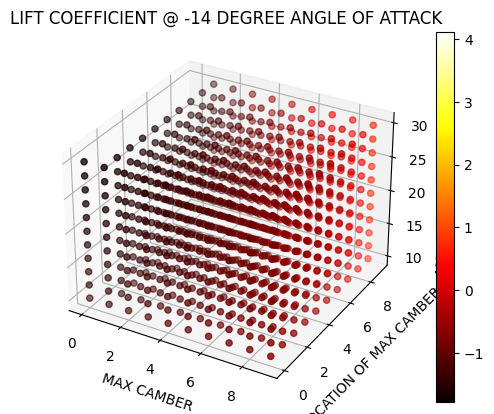

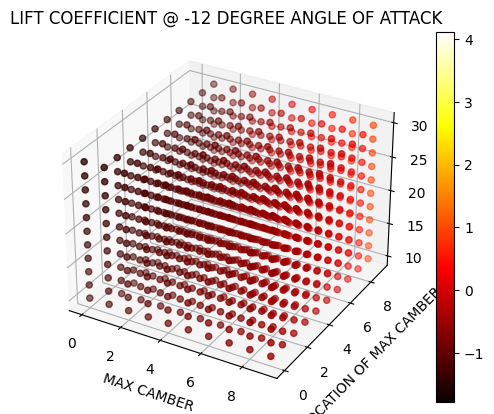

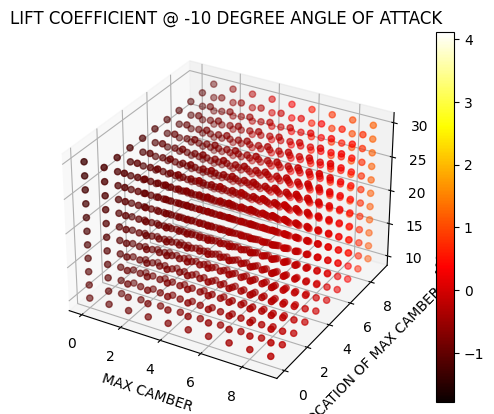

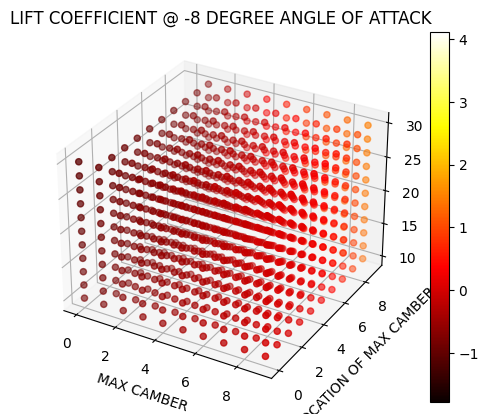

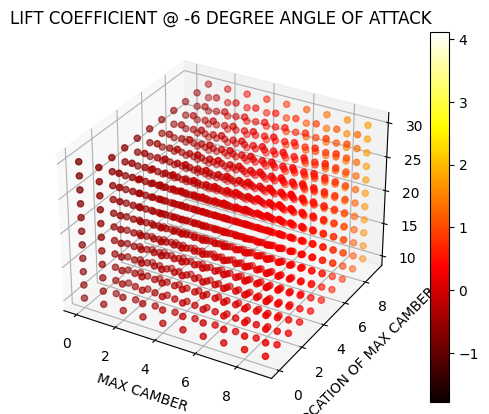

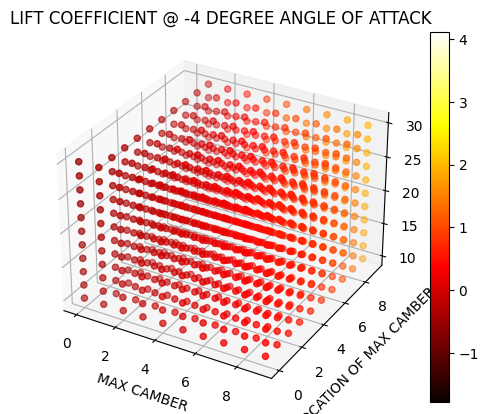

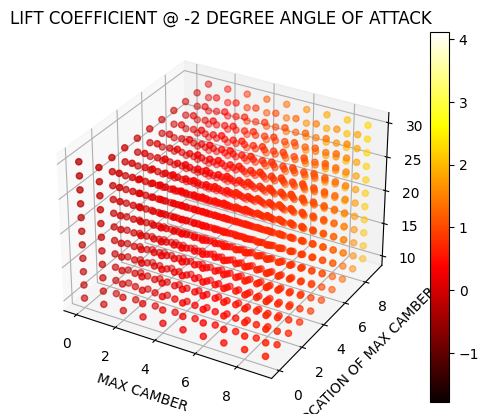

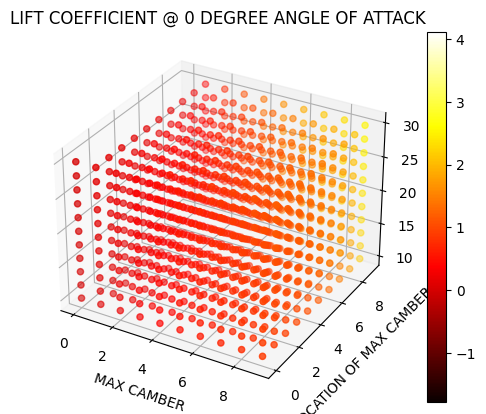

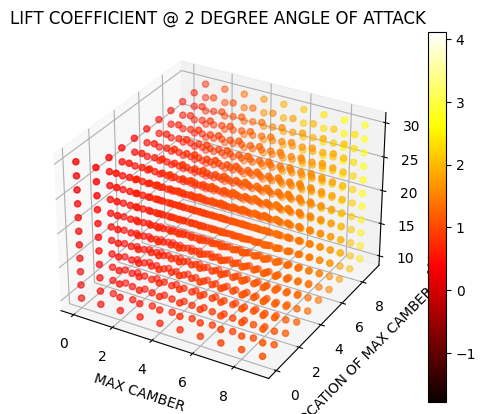

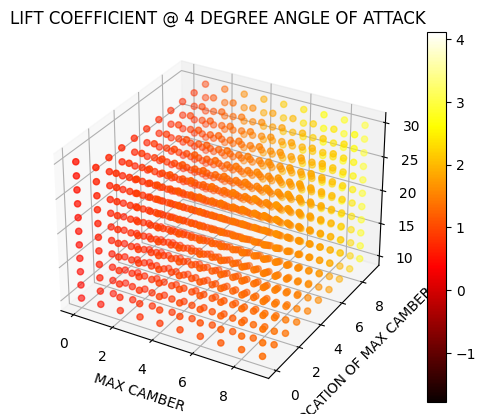

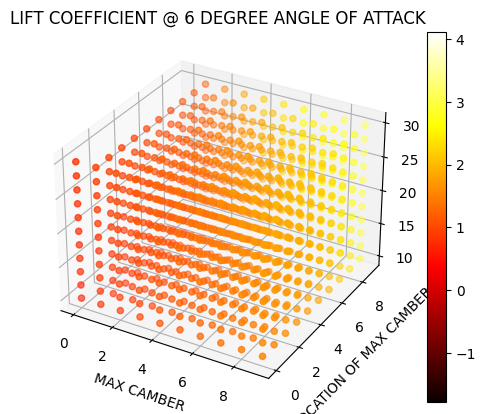

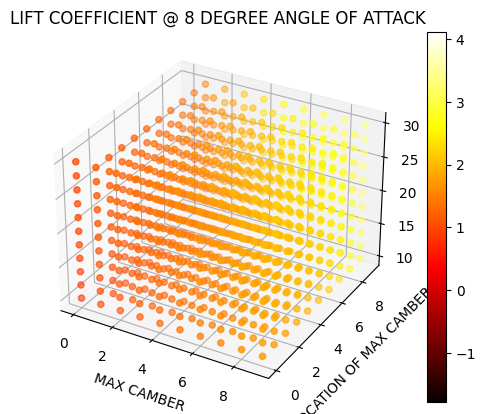

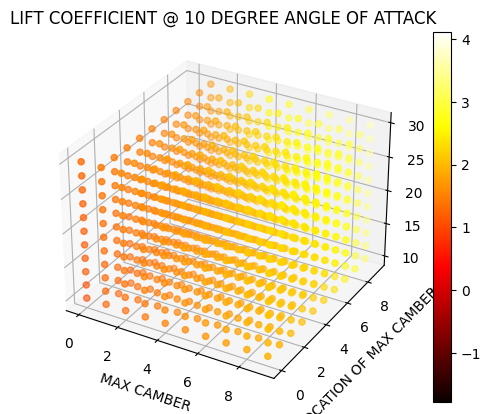

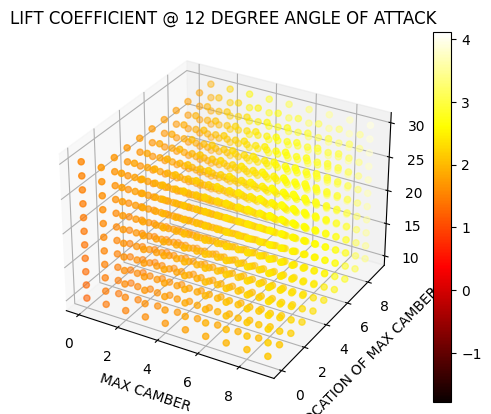

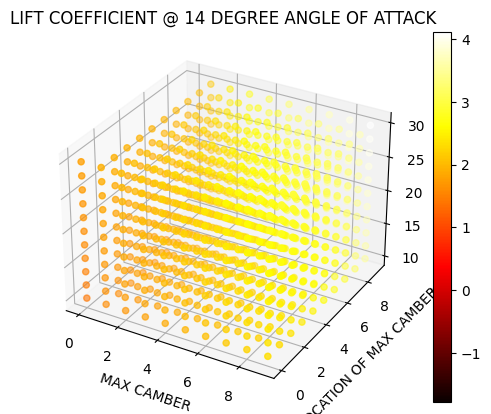

In [ ]:
# Let's start by taking a look at the lift coefficient as a function of maximal
# camber, location of maximal camber, and maximum thickness while keeping angle
# of attack constant

attack_angles = sorted(wing_data['ATTACK_ANGLE'].unique())
LIFT_COEFFS = wing_data['STD_LIFT']
max_lift = LIFT_COEFFS.max()
min_lift = LIFT_COEFFS.min()
for aoa in attack_angles:
  X = wing_data[wing_data['ATTACK_ANGLE'] == aoa]['MAX_CAMBER']
  Y = wing_data[wing_data['ATTACK_ANGLE'] == aoa]['MAX_CAMBER_LOC']
  Z = wing_data[wing_data['ATTACK_ANGLE'] == aoa]['MAX_PERCENT_THICKNESS']
  LIFT_COEFFS = wing_data[wing_data['ATTACK_ANGLE'] == aoa]['STD_LIFT']
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  p = ax.scatter(X, Y, Z, c = LIFT_COEFFS, vmin = min_lift, vmax = max_lift, marker = 'o', cmap = 'hot')
  ax.set_xlabel('MAX CAMBER')
  ax.set_ylabel('LOCATION OF MAX CAMBER')
  ax.set_zlabel('MAX PERCENT THICKNESS')
  ax.set_title('LIFT COEFFICIENT @ ' + str(aoa) + ' DEGREE ANGLE OF ATTACK')
  fig.colorbar(p)

In [ ]:
# We can see some general trends in this data from this plot alone. It looks
# like as angle of attack increases, the lift generated by an airfoil also
# increases. From the gradients of the plots, it looks like as max camber,
# location of max camber, and max percent thickness increase, the lift
# coefficient also tends to increase. As you Go from the bottom left of the
# graph up to the top right, the colors become much hotter.

# Let's try to verify these trends with some statistical tests

Pearson correlation test:
	 Correlation coefficient: 0.8988792938703398
	 P-value: 0.0


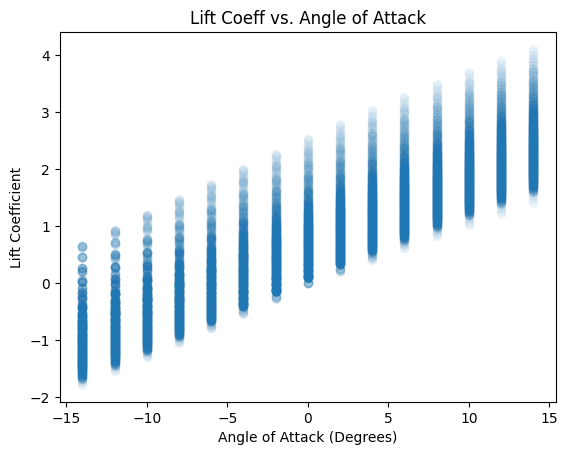

In [ ]:
# We'll start by looking at the effect of angle of attack on lift coefficient
# Null hypothesis: The lift coefficient of an airfoil has no correlation to the
# angle of attack of that airfoil.
# Alternative hypothesis: The lift coefficient of an airfoil is correlated to
# the angle of attack of that airfoil.
# ALPHA VALUE: 0.05
# We use a pearson correlation test here because the data follows a linear
# trend and has a rough normal distribution to it.
X = wing_data['ATTACK_ANGLE']
Y = wing_data['STD_LIFT']
plt.scatter(X, Y, alpha = 0.05)
plt.title('Lift Coeff vs. Angle of Attack')
plt.xlabel('Angle of Attack (Degrees)')
plt.ylabel('Lift Coefficient')
result = sp.stats.pearsonr(X, Y)
print('Pearson correlation test:')
print(f'\t Correlation coefficient: {result.statistic}')
print(f'\t P-value: {result.pvalue}')

In [ ]:
# We have a correlation coefficient of 0.89, which suggests that lift
# coefficient are strongly correlated. In addition, our P-value is 0.0.
# In reality, it's probably not exactly 0, but due to floating point precision,
# it is effectively 0. So, we can reject the null hypothesis and claim that
# The lift coefficient of an airfoil is correlated to the attack angle of that
# airfoil

Spearman rank order correlation test:
	 Correlation coefficient: 0.33030160166350186
	 P-value: 0.0


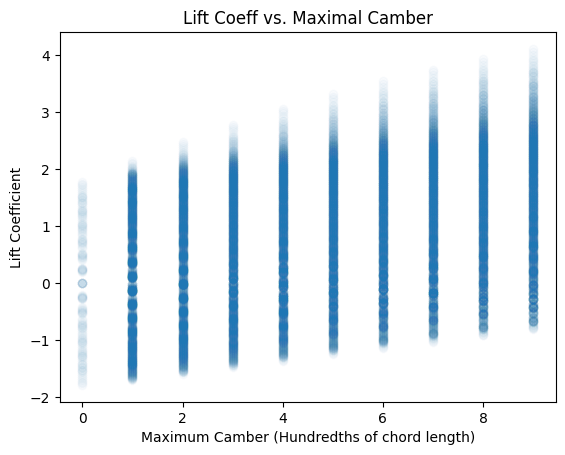

In [ ]:
# Now, let's look at the effect of maximum airfoil camber on lift coefficient
# Null hypothesis: The lift coefficient of an airfoil has no correlation to the
# height of maximal camber of that airfoil.
# Alternative hypothesis: The lift coefficient of an airfoil is correlated to
# the height of maximal camber of that airfoil.
# ALPHA VALUE: 0.05
# We use a spearman correlation test here because although the data has a linear
# trend to it, the variance seems to increase as maximum camber increases
X = wing_data['MAX_CAMBER']
Y = wing_data['STD_LIFT']
plt.scatter(X, Y, alpha = 0.025)
plt.title('Lift Coeff vs. Maximal Camber')
plt.xlabel('Maximum Camber (Hundredths of chord length)')
plt.ylabel('Lift Coefficient')
result = sp.stats.spearmanr(X, Y)
print('Spearman rank order correlation test:')
print(f'\t Correlation coefficient: {result.statistic}')
print(f'\t P-value: {result.pvalue}')

Spearman rank order correlation test:
	 Correlation coefficient: 0.20785502249979246
	 P-value: 3.286590947633836e-146


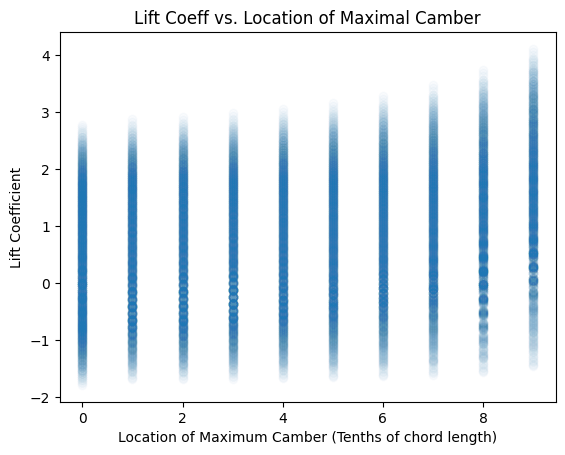

In [ ]:
# Now, let's look at the effect of maximum airfoil camber location on lift coefficient
# Null hypothesis: The lift coefficient of an airfoil has no correlation to the
# location of maximal camber of that airfoil.
# Alternative hypothesis: The lift coefficient of an airfoil is correlated to
# the location of maximal camber of that airfoil.
# ALPHA VALUE: 0.05
# We also use a spearman correlation test here because the data follows a
# nonlinear trend and the variance and normality of the distribution change
# with increase maximal camber locations
X = wing_data['MAX_CAMBER_LOC']
Y = wing_data['STD_LIFT']
plt.scatter(X, Y, alpha = 0.025)
plt.title('Lift Coeff vs. Location of Maximal Camber')
plt.xlabel('Location of Maximum Camber (Tenths of chord length)')
plt.ylabel('Lift Coefficient')
result = sp.stats.spearmanr(X, Y)
print('Spearman rank order correlation test:')
print(f'\t Correlation coefficient: {result.statistic}')
print(f'\t P-value: {result.pvalue}')

In [ ]:
# We have a correlation coefficient of 0.207, which suggests that lift
# coefficient is somewhat corrrelated to location of maximum camber. Our p-value
# is also extremely close to 0, being 3.2 * 10^-146. This P-value is
# significantly less than the alpha-value of 0.05, so we can reject the null
# hypothesis and claim that the lift coefficient of an airfoil is correlated
# to the location of maximal camber on that airfoil.
#
# An interesting observation with this plot is that Lift coefficient and
# location of maximal camber seem to be related via a quadratic. We aren't
# particularly sure why this is the case, but a cool fact is that in
# aerodynamics, a lot of relationships between geometries of solid objects and
# their surrounding fluids tend to be quadratic.

Pearson correlation test:
	 Correlation coefficient: 0.0440829459622291
	 P-value: 6.520287051698969e-08


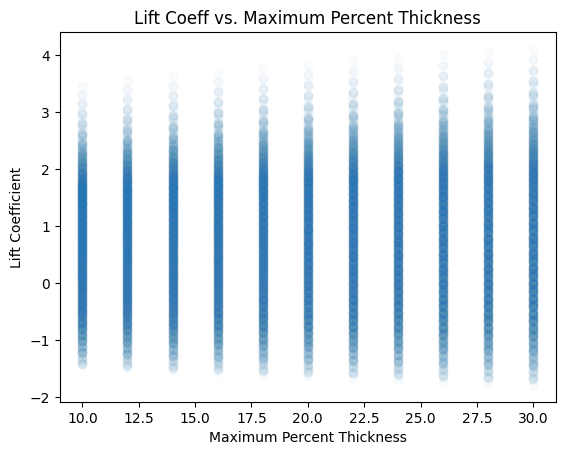

In [ ]:
# Now, let's look at the effect of maximum airfoil thickness on lift coefficient
# Null hypothesis: The lift coefficient of an airfoil has no correlation to the
# maximum percent thickness of that airfoil.
# Alternative hypothesis: The lift coefficient of an airfoil is correlated to
# the the maximum percent thickness of that airfoil.
# ALPHA VALUE: 0.05
# Here, we use a pearson correlation test again because the data appears to
# follow a linear trend. One could argue for the use of a spearman correlation
# test again since the variance appears to change ever so slightly around
# lower percent thicknesses, but it does not change much.
X = wing_data['MAX_PERCENT_THICKNESS']
Y = wing_data['STD_LIFT']
plt.scatter(X, Y, alpha = 0.025)
plt.title('Lift Coeff vs. Maximum Percent Thickness')
plt.xlabel('Maximum Percent Thickness')
plt.ylabel('Lift Coefficient')
result = sp.stats.pearsonr(X, Y)
print('Pearson correlation test:')
print(f'\t Correlation coefficient: {result.statistic}')
print(f'\t P-value: {result.pvalue}')

In [ ]:
# We have a correlation coefficient of 0.044, which suggests that lift
# coefficient is ever so slightly correlated to maximum percent thickness.
# Our P-value is 6.52 * 10^-8. So, we can reject the null hypothesis and claim that
# The lift coefficient of an airfoil is correlated to the attack angle of that
# airfoil since the P-value is much less than the alpha-value of 0.05.
#
# The relatively weak correlation between the two variables is also in agreement
# with conclusions from potential flow theory. For thin airfoils, which is what
# this dataset is comprised of, the lifting properties of an airfoil are barely
# Affected by the thickness of that airfoil.

### INVESTIGATION 3: Differences between symmetric and asymmetric airfoils

In [ ]:
# The last thing we want to investigate here is the impact of symmetry on the
# lift coefficient of an airfoil. Specifically, we want to compare the means of
# the symmetric airfoil lift coefficients and asymmetric airfoil lift
# coefficients.

Text(0, 0.5, 'Frequency')

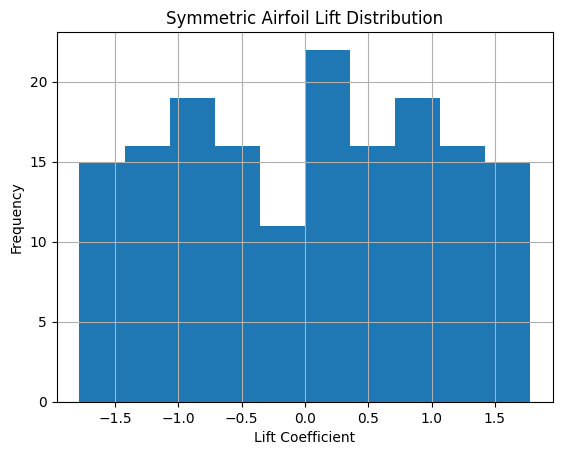

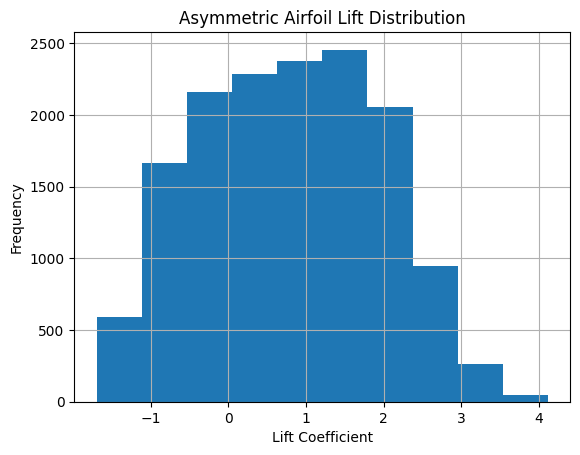

In [ ]:
# Let's start by plotting histograms of the two distributions to see what type
# of test we should use (T-test or Mann-Whitney U-test?)

SYMMETRIC_LIFTS = wing_data[wing_data['IS_SYMMETRIC']]['STD_LIFT']
ASYMMETRIC_LIFTS = wing_data[wing_data['IS_SYMMETRIC'] == False]['STD_LIFT']
plt.figure()
SYMMETRIC_LIFTS.hist()
plt.title('Symmetric Airfoil Lift Distribution')
plt.xlabel('Lift Coefficient')
plt.ylabel('Frequency')
plt.figure()
ASYMMETRIC_LIFTS.hist()
plt.title('Asymmetric Airfoil Lift Distribution')
plt.xlabel('Lift Coefficient')
plt.ylabel('Frequency')

In [ ]:
# The symmetric airfoil lift distribution does not appear to be normal,
# so we will use the nonparametric form of the unpaired t-test, the
# Mann-Whitney U-test
# Null Hypothesis: There is no difference in the median lift coefficient
# of symmetric and asymmetric airfoils under all angle of attacks
# Alternate Hypothesis: The median lift coefficient asymmetric airfoils is
# greater than that of symmetric airfoils under all angle of attacks
# ALPHA VALUE: 0.05
result = sp.stats.mannwhitneyu(SYMMETRIC_LIFTS, ASYMMETRIC_LIFTS, alternative = 'less')
print('Mann-Whitney U-test:')
print(f'P-value: {result.pvalue}')

Mann-Whitney U-test:
P-value: 2.6520587488262557e-17


In [ ]:
# Based on the result of the above Mann-Whitney U-test, it is safe for us to
# reject the null hypothesis. The p-value is 2.65 * 10^-17, which is signficantly
# less than the alpha-value of 0.05. So, we can conclude that asymmetric airfoils
# have a median lift coefficient greater than symmetric airfoils under all
# attack angles

## PRIMARY MACHINE LEARNING ANALYSIS

### MODEL SELECTION

Given the continuous nature of our problem, some sort of machine learning model that deals with continuous inputs and outputs should be used. A linear regressor would be the easiest to implement, but given the nonlinear relationships of our data and the non-normal distributions, a neural-network approach seems to be the best option to capture all relationships present in the data.

### PREPPING DATA

First, let's drop the "KJ_LIFT" column of our dataframe. This is essentially the "STD_LIFT" column, but calculated using the Kutta-Joukowski lift theorem.
We don't want this to feed straight through the neural network, since we want
to determine lift from airfoil geometries only.

In [ ]:
wing_data = wing_data.drop(["KJ_LIFT"], axis=1)

Now, let's do a one hot encoding on the IS_SYMMETRIC field. Since it is currently a boolean and sklearn's one hot encoder prefers categorical data, we will do this manually by adding an IS_ASYMMETRIC field that is the negation of the IS_SYMMETRIC field. Additionally, we will convert it the two rows to integers so our neural network can process them properly.

In [ ]:
wing_data["IS_ASYMMETRIC"] = ~wing_data["IS_SYMMETRIC"]
wing_data["IS_ASYMMETRIC"] = wing_data["IS_ASYMMETRIC"].apply(lambda x: int(x))
wing_data["IS_SYMMETRIC"] = wing_data["IS_SYMMETRIC"].apply(lambda x: int(x))

With all preprocessing finally done, we can start developing a neural network to predict the lift properties of airfoils.

We will start with a simpler neural network. We won't put in all the values of
the cambers and thicknesses; we will just use the maximum values which we used
to do our exploratory data analysis in conjunction with the symmetry fields and attack angle fields. We are doing this just to see how accurate we can get with as little information about an airfoil and its configuration as possible.


In [ ]:
# SORT DATA INTO TARGET VARS AND INPUT VARS
y = wing_data['STD_LIFT']
X = wing_data[['IS_SYMMETRIC', 'IS_ASYMMETRIC', 'MAX_CAMBER_LOC', 'MAX_CAMBER', 'MAX_PERCENT_THICKNESS', 'ATTACK_ANGLE']]
print(X)

       IS_SYMMETRIC  IS_ASYMMETRIC  MAX_CAMBER_LOC  MAX_CAMBER  \
0                 1              0               0           0   
1                 1              0               0           0   
2                 1              0               0           0   
3                 1              0               0           0   
4                 1              0               0           0   
...             ...            ...             ...         ...   
15010             0              1               9           9   
15011             0              1               9           9   
15012             0              1               9           9   
15013             0              1               9           9   
15014             0              1               9           9   

       MAX_PERCENT_THICKNESS  ATTACK_ANGLE  
0                         10           -14  
1                         10           -12  
2                         10           -10  
3                         1

Next, let's split our data into a training and test set.

In [ ]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_test)

       IS_SYMMETRIC  IS_ASYMMETRIC  MAX_CAMBER_LOC  MAX_CAMBER  \
2514              0              1               4           2   
6649              0              1               9           4   
11873             0              1               0           8   
11010             0              1               5           7   
2748              0              1               5           2   
...             ...            ...             ...         ...   
14561             0              1               7           9   
13909             0              1               3           9   
8553              0              1               0           6   
4990              0              1               9           3   
11131             0              1               6           7   

       MAX_PERCENT_THICKNESS  ATTACK_ANGLE  
2514                      14             4  
6649                      16            -6  
11873                     30             2  
11010                     2

Now, let's standardize our data so that the importance of each feature is weighted approximately equally before beginning. We will do this with a StandardScaler from sklearn. Let's also convert the data to pytorch tensors so
we can use pytorch's neural networks.

In [ ]:
#STANDARDIZE
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_test)
# CONVERT TO TENSOR
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

[[-0.10780553  0.10780553 -0.15608681 -1.12991878 -0.95105094  0.46773044]
 [-0.10780553  0.10780553  1.57577607 -0.36481354 -0.63621812 -0.69069802]
 [-0.10780553  0.10780553 -1.54157711  1.16539693  1.56761167  0.23604475]
 ...
 [-0.10780553  0.10780553 -1.54157711  0.4002917   1.25277884 -0.92238371]
 [-0.10780553  0.10780553  1.57577607 -0.74736616 -0.95105094  0.69941613]
 [-0.10780553  0.10780553  0.53665834  0.78284432 -0.00655246 -1.38575509]]


Next, let's convert our X_train and y_train datasets into a TensorDataset
to train the neural network. Let's also create a DataLoader to dispense batches of entries when training the neural network with whatever optimizer we choose.

In [ ]:
# CREATE TRAINING DATASET
training_dataset = TensorDataset(X_train, y_train)

# MAKE A DATA LOADER TO DISPENSE BATCHES OF POINTS FROM THE DATA SET
training_loader = DataLoader(training_dataset, batch_size = 128, shuffle = True)

### MODEL CREATION AND TRAINING

We can finally define a neural network class for our problem. Let's start off with only one hidden layer of 128 nodes.

In [ ]:
# DEFINE NEURAL NETWORK CLASS
class Wing_Lift_Predictor(nn.Module):

    # CONSTRUCTOR
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    # FORWARD PROPAGATION
    def forward(self, x):
        return self.linear_relu_stack(x)

Now, let's choose a loss function and a neural network optimizer. Given that our output is a single floating-point number, we will use a mean squared error loss function (MSE), and we will use the Adam optimizer to tweak our model parameters.

In [ ]:
# CREATE A LOSS FUNCTION
criterion = nn.MSELoss()

# CREATE A MODEL
model = Wing_Lift_Predictor()

# DEFINE OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr = 0.001)

After having all of the key parts to our network properly defined, we can finally train it. Let's start with 100 epochs and see how it performs. Just to gauge the performance of the network over training, we will also plot the MSE loss with each training epoch.

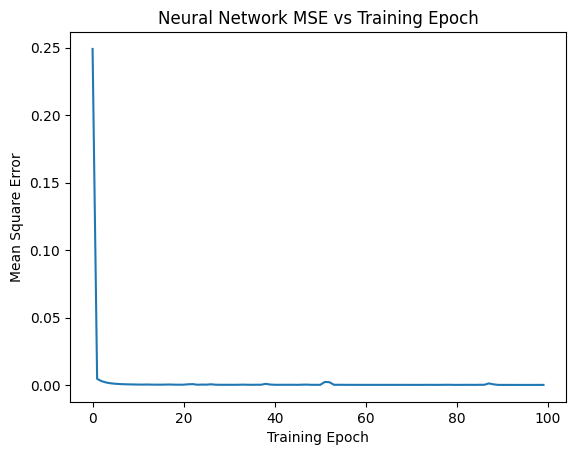

In [ ]:
# NUMBER OF ITERATIONS
num_iter = 100

# ARRAY TO HOLD LOSSES
losses = []

# PERFORM THE TRAINING ITERATIONS AND BACKPROPAGATE WITH ADAM
model.train(mode=True)
for i in range(num_iter):
  curr_loss = 0;
  for X_mini, y_mini in training_loader:
    optimizer.zero_grad()
    prediction = model(X_mini)
    loss = criterion(prediction, y_mini.unsqueeze(1))
    loss.backward()
    optimizer.step()
    curr_loss += loss.item()
  losses.append(curr_loss / len(training_loader)) #Average the loss over the past batches
model.train(mode=False)

# PLOT LOSS AS A FUNCTION OF TRAINING ITER
plt.plot(losses)
plt.xlabel('Training Epoch')
plt.ylabel('Mean Square Error')
plt.title('Neural Network MSE vs Training Epoch')
plt.show()

Wow, that's really unexpected. A MSE of near zero after only a couple training epochs. This either means that our neural network did an exceptional job at picking up the underlying relationships between our dependent and independent variables, or it is horribly overfitting.

Let's validate the model on our test set to check if we are or are not overfitting.

In [ ]:
y_test_pred = model(X_test)
loss = criterion(y_test_pred, y_test.unsqueeze(1))
print(f'MSE loss of neural net on test set: {loss.item()}')

MSE loss of neural net on test set: 4.1200390114681795e-05


With such a low MSE loss on the test set, we can safely conclude that our neural network has found the underlying relationships between our variables.

### POST-TRAINING AND POST-VERIFICATION ANALYSIS


Let's take a look at the model's prediction of an airfoil's lift and compare it to the lift calculated by the 2D panel method code used to generate our data on. We will use an airfoil that hasn't been seen by the neural network and hasn't been calculated with our panel code before.

For this test case, we will use an airfoil with the following properties:\
MAX_PERCENT_THICKNESS = 14.5\
MAX_CAMBER = 8.23\
MAX_CAMBER_LOC = 5.5\
ATTACK_ANGLE = 10\
IS_SYMMETRIC = 0\
IS_ASYMMETRIC = 1

From our panel method code, we compute a lift coefficient of about 2.1991.

Here is the general shape of the airfoil:
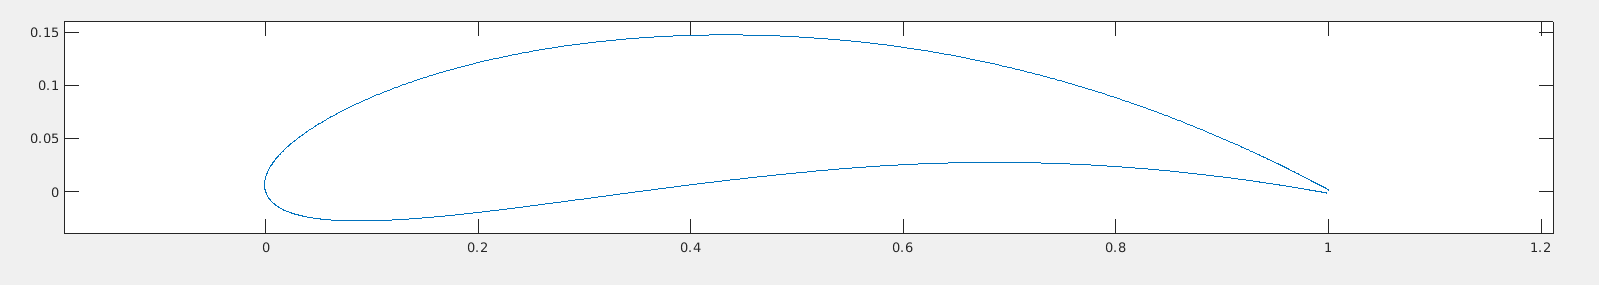

And here is the pressure coefficient plot of the airfoil:
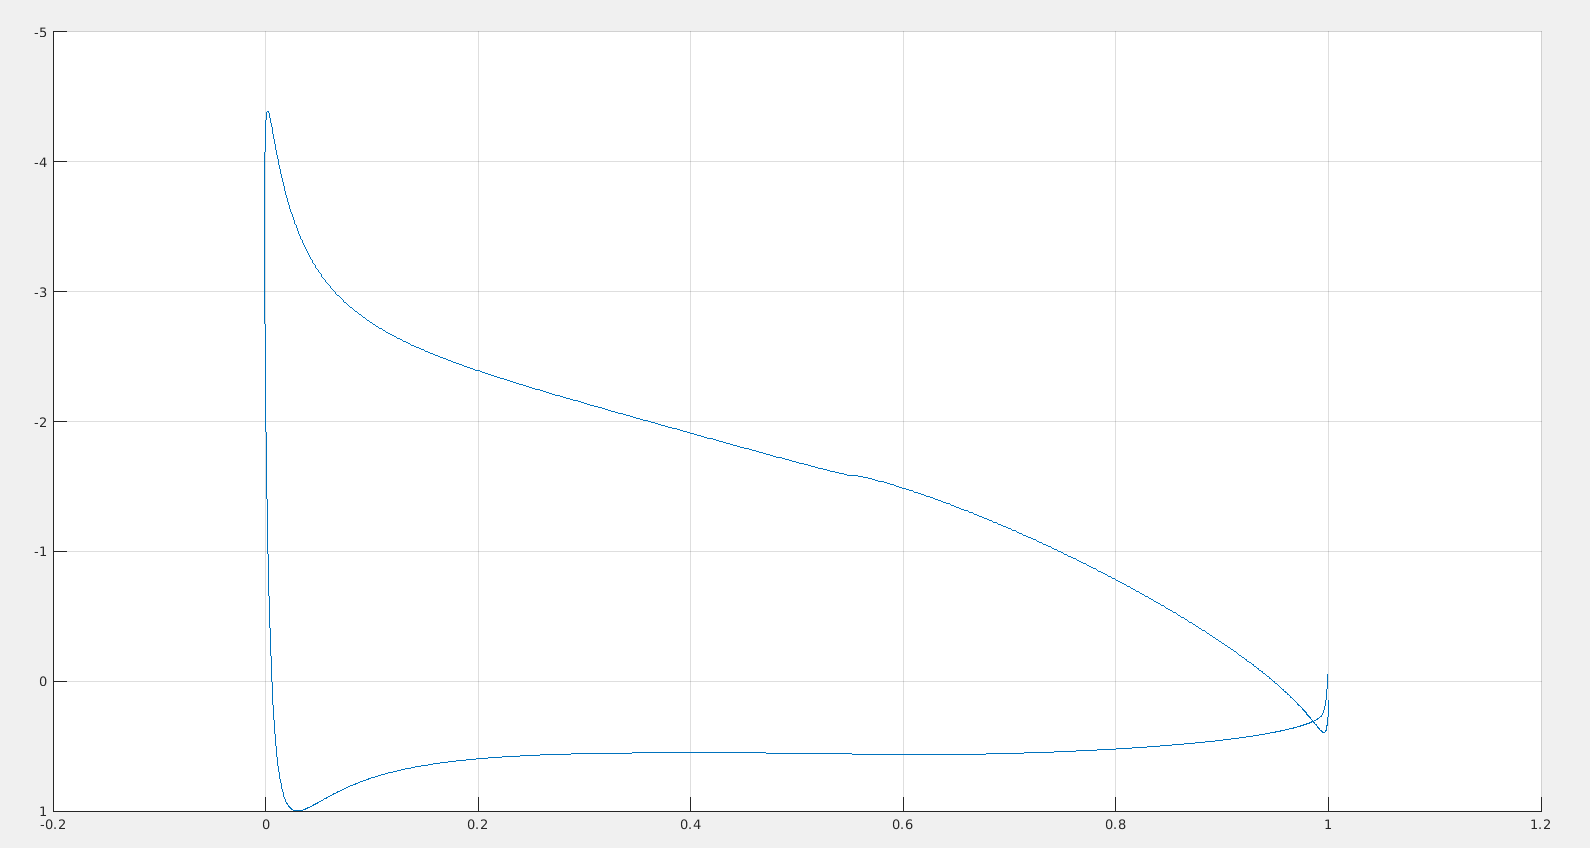

Dimensions were not included in the above figures because all of the quantities are dimensionless. Numerically integrating the area enclosed by the pressure coefficient curve results in the lift coefficient of the airfoil.

However, computing all of these quantities takes a long time because of the nature of the numerical method used. Panel methods require the inversion of extremely large matrices (in this case, about a 2000x2000 matrix inversion, but for more sophisticated problems, can require inversions of 10000x10000 or 20000x20000 matrices). In addition to this matrix inversion, calculating the coefficients in each entry in the matrix is an additional set of computations which are the most time consuming in the process.

By using a simple yet concise neural network, computational time can be greatly reduced. This neural network has only one hidden layer of 128 nodes, meaning there are very few calculations in comparison to generating the coefficients in the 2000x2000 matrix and then inverting it, followed by more numerical integration to get just one number.

With the panel method code provided in our github repo for this project, feel free to change the airfoil parameters and compare the panel method code results with this neural network's results for the same configuration.

In [ ]:
# Our independent variables
MAX_PERCENT_THICKNESS = 14.5
MAX_CAMBER = 8.23
MAX_CAMBER_LOC = 5.5
ATTACK_ANGLE = 10
IS_SYMMETRIC = 0
IS_ASYMMETRIC = 1

# Define our test case vector
X = {'IS_SYMMETRIC': [IS_SYMMETRIC], \
     'IS_ASYMMETRIC': [IS_ASYMMETRIC], \
     'MAX_CAMBER_LOC': [MAX_CAMBER_LOC], \
     'MAX_CAMBER': [MAX_CAMBER], \
     'MAX_PERCENT_THICKNESS': [MAX_PERCENT_THICKNESS], \
     'ATTACK_ANGLE': [ATTACK_ANGLE]}
X = pd.DataFrame.from_dict(X)

y_theory = 2.1991 # This is from our panel method code

# Let's scale the X vector
X = scaler.transform(X)

# And convert it to a tensor
X = torch.tensor(X, dtype=torch.float32)

y_predict = model(X)

print(f'Lift coefficient from numerical method: {y_theory}')
print(f'Lift coefficient from neural network: {y_predict.item()}')
percent_error = (y_predict.item() - y_theory) / y_theory * 100
print(f'Model Percent Error: {percent_error}%')


Lift coefficient from theory: 2.1748
Lift coefficient from neural network: 2.299757719039917
Model Percent Error: 5.745710825819255%


From our model, we predict a lift coefficient of 2.299, which only deviates from reality by about 5.7%, suggesting great performance of the model for its relative simplicity in the context and scale of the problem.

### A SECONDARY MODEL

Just to see if we can improve the accuracy of our neural network, we will keep EVERYTHING the same except the number of inputs to the neural network. Does knowing the airfoil camber and thickness at every tenth of the chord length improve the performance at all? Everything in the following code will be the same, so we won't narrate as much of it.

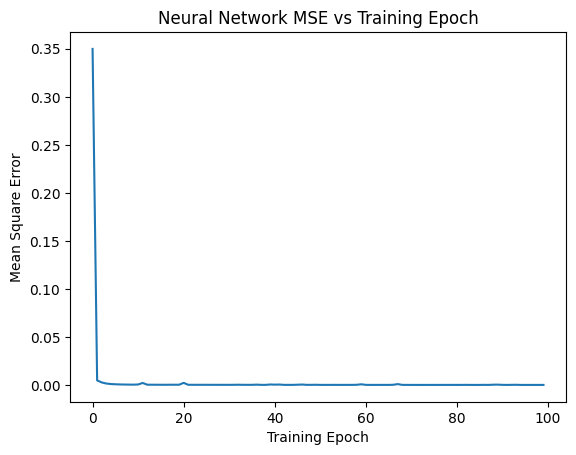

MSE loss of neural net on test set: 2.8784344976884313e-05


In [ ]:
# SORT DATA INTO TARGET VARS AND INPUT VARS
y2 = wing_data['STD_LIFT']
X2 = wing_data[wing_data.columns.difference(['STD_LIFT'])]

# SPLIT DATA
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

# STANDARDIZE DATA
scaler2 = StandardScaler()
scaler2.fit(X_train2)
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

# CONVERT TO PYTORCH TENSOR
X_train2 = torch.tensor(X_train2, dtype=torch.float32)
X_test2 = torch.tensor(X_test2, dtype=torch.float32)
y_train2 = torch.tensor(y_train2.to_numpy(), dtype=torch.float32)
y_test2 = torch.tensor(y_test2.to_numpy(), dtype=torch.float32)

# CREATE TRAINING DATASET
training_dataset2 = TensorDataset(X_train2, y_train2)

# MAKE A DATA LOADER TO DISPENSE BATCHES OF POINTS FROM THE DATA SET
training_loader2 = DataLoader(training_dataset2, batch_size = 128, shuffle = True)

# DEFINE NEURAL NETWORK CLASS
class Wing_Lift_Predictor2(nn.Module):

    # CONSTRUCTOR
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    # FORWARD PROPAGATION
    def forward(self, x):
        return self.linear_relu_stack(x)

# CREATE A LOSS FUNCTION
criterion2 = nn.MSELoss()

# CREATE A MODEL
model2 = Wing_Lift_Predictor2()

# DEFINE OPTIMIZER
optimizer2 = optim.Adam(model2.parameters(), lr = 0.001)

# NUMBER OF ITERATIONS
num_iter2 = 100

# ARRAY TO HOLD LOSSES
losses2 = []

# PERFORM THE TRAINING ITERATIONS AND BACKPROPAGATE WITH ADAM
model2.train(mode=True)
for i in range(num_iter2):
  curr_loss2 = 0;
  for X_mini2, y_mini2 in training_loader2:
    optimizer2.zero_grad()
    prediction2 = model2(X_mini2)
    loss2 = criterion2(prediction2, y_mini2.unsqueeze(1))
    loss2.backward()
    optimizer2.step()
    curr_loss2 += loss2.item()
  losses2.append(curr_loss2 / len(training_loader2))
model2.train(mode=False)

# EVOLUTION OF MODEL ERROR
plt.plot(losses2)
plt.xlabel('Training Epoch')
plt.ylabel('Mean Square Error')
plt.title('Neural Network MSE vs Training Epoch')
plt.show()

# MODEL VALIDATION WITH TEST DATA
y_test_pred2 = model2(X_test2)
loss2 = criterion(y_test_pred2, y_test2.unsqueeze(1))
print(f'MSE loss of neural net on test set: {loss2.item()}')

Well, it looks to have about the same performance. From the loss curve it looks like it converges slightly faster, but certainly not enough to warrant using so many input parameters.

Perhaps if our training data included more complex geometries, these inputs would be more useful. For 4-digit NACA airfoils, the mean camber line and thicknesses are defined exactly the same, except for just a scaling factor and a shifting factor, So from our simpler (6-input) model, it was able to infer this geometry internally. With the complex model (28-input), the geometry was explicitly defined, and had not much significance on the performance.

## INSIGHTS AND CONCLUSIONS

Following the above analysis, it is clear that simple data science techniques can be used in conjunction with aerodynamic theory to create simple models of complex systems.

With a few statistical tests, we were able to determine relationships between independent and dependent variables regarding the performance of an airfoil and its configuration. We deduced through correlation tests that the angle of attack of an airfoil is strongly and positively related to the lift generated by an airfoil, and that the magnitude of lift coefficient of an airfoil generally increases with larger maximal camber, larger thicknesses, and a more rearward maximal camber location. From aerodynamic theory alone, deducing all of these is not easily doable, but the statistical tests on our data made these relationships apparent.

Additionally, the theory regarding incompressible and inviscid aerodynamics is a vast and complex topic, with varying approaches. No one solution to this type of problem is "the best", and many are incredibly computationally expensive. By training a neural network on theoretical data, we have created a relatively simple model for this complex problem. This model was able to accurately pick up the underlying nonlinear relationships in our data, and was also able to generalize to unseen airfoil geometries and configurations with ~5% error.

Altogether, we have shown that data science techniques are a viable approach to modeling airfoils. Our final neural network has 6 inputs, 1 output, and 128 nodes in a single hidden layer. This small network was plenty to capture all of the nonlinear and complex relationships in our data that humans are unable to detect, with the time required to calculate the lift of a given airfoil being close to zero seconds. This is an incredible performance improvement compared to the original panel method code solution, which takes several seconds (and up to several minutes for high-fidelity results) to compute a solution.

Future iterations of this project would include acquiring training data from other sources rather than just a single 2D panel method solver. Some other sources could be experimental wind tunnel data, thin airfoil theory equations, and other types of computational fluid dynamics. Combining different solutions to characterizing airfoils and training a neural network on them could lead to a superior model which properly captures most aspects of an airfoil's geometry and its influences on its lifting properties.

## (SUPPLEMENTARY) PANEL METHOD CODES: HOW THEY WORK

From fluid dynamics, there are several governing equations that dictate how a fluid flows. Combining all of these equations in their differential form yields the Navier-Stokes, which is an incredibly complex system to solve. Simplifications to this system have been made to make approximating solutions to flow problems easier, and one of those simplifications has been assuming incompressible (the density of the fluid cannot change) and inviscid (there are no viscous effects, like when you see honey pour out of a jar) flow.

Under these assumptions, the mass-balance equation (commonly referred to as the continuity equation) simplifies to tell us one thing about the velocity field surrounding the airfoil: It is divergence free (div(V) = 0).

Next, by making the assumption of inviscid flow, the velocity field becomes conservative. From calculus III and differential equations, we can recall that conservative fields can be expressed as the gradient of a potential field, phi. So, we can say V = grad(phi).

With these two assumptions, we can say that for a potential field, phi, surrounding an airfoil, div(grad(phi)) = 0. This equation is known as Laplace's equation, and comes up in many areas of physics.

Solving this equation for an arbitrary airfoil is incredibly hard, if not impossible, so people have devised ways to approximate the solutions numerically. This is where panel methods come in. We can superimpose fundamental solutions to laplace's equation to numerically satisfy the physicality requirement of flow around an airfoil, which is that there should be no flow through the surface of the airfoil. (dot(grad(phi), surface_normal) = 0). One of these solutions is a vortex flow, which is essentially a flow that spins around a point with a velocity inversely proportional to the distance to the point.

If you can approximate the boundary of an airfoil with a set of straight edges, and give each of those straight edges a constant "vortex strength" (essentially a vortex flow stretched out over the edge), and satisfy the no thru-flow boundary condition, you have effectively solved for the flowfield surrounding the airfoil.

Following this, simplifying the momentum-balance equation for an inviscid, incompressible flow yields Bernoulli's equation, which relates the velocity of a flowfield to its pressure. Using Bernoulli's equation in conjunction with the numerically calculated flowfield, it becomes a matter of substituion to determine the pressure (and the pressure coefficient) at each point along the surface of the airfoil, and then numerically integrate those pressures/pressure coefficients to acquire the lifting force and lift coefficient of that airfoil in a given configuration.

You can see the exact implementation in the Vortex_Panel_Method_2D.m file in our repo. This program was written in MATLAB prior to the start of this course, but all of our data analysis of the results was done in Python.

From this program, here are sample results for a NACA-2412 airfoil at a 10 degree angle of attack:
Standard Lift Coefficient: 1.2953
Kutta-Joukowski Lift Coefficient: 1.3173

Pressure Coefficient Plot:
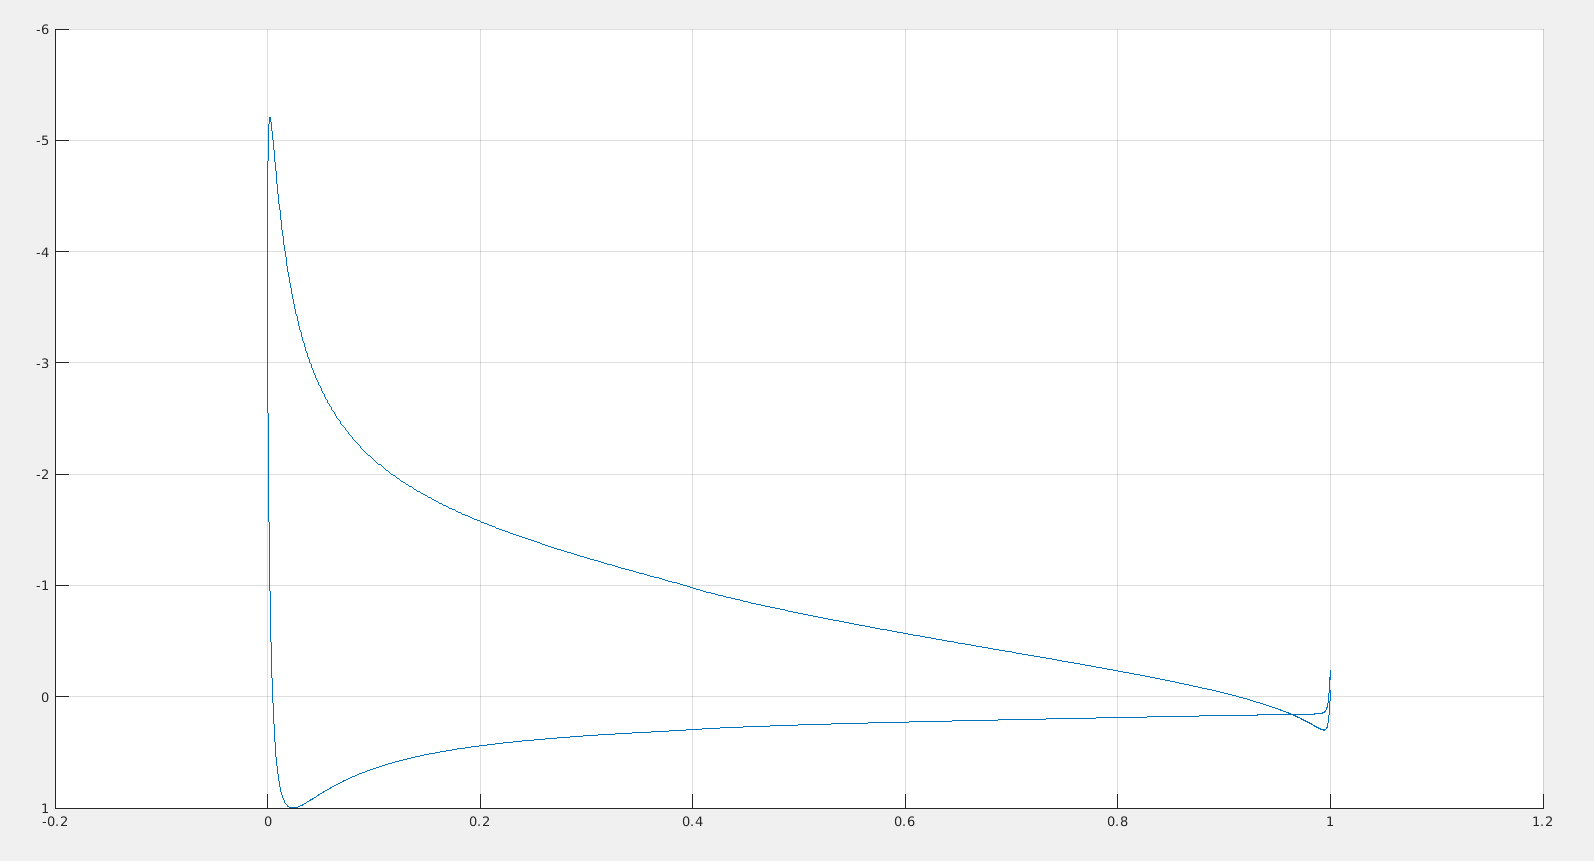

Streamline Visualization:
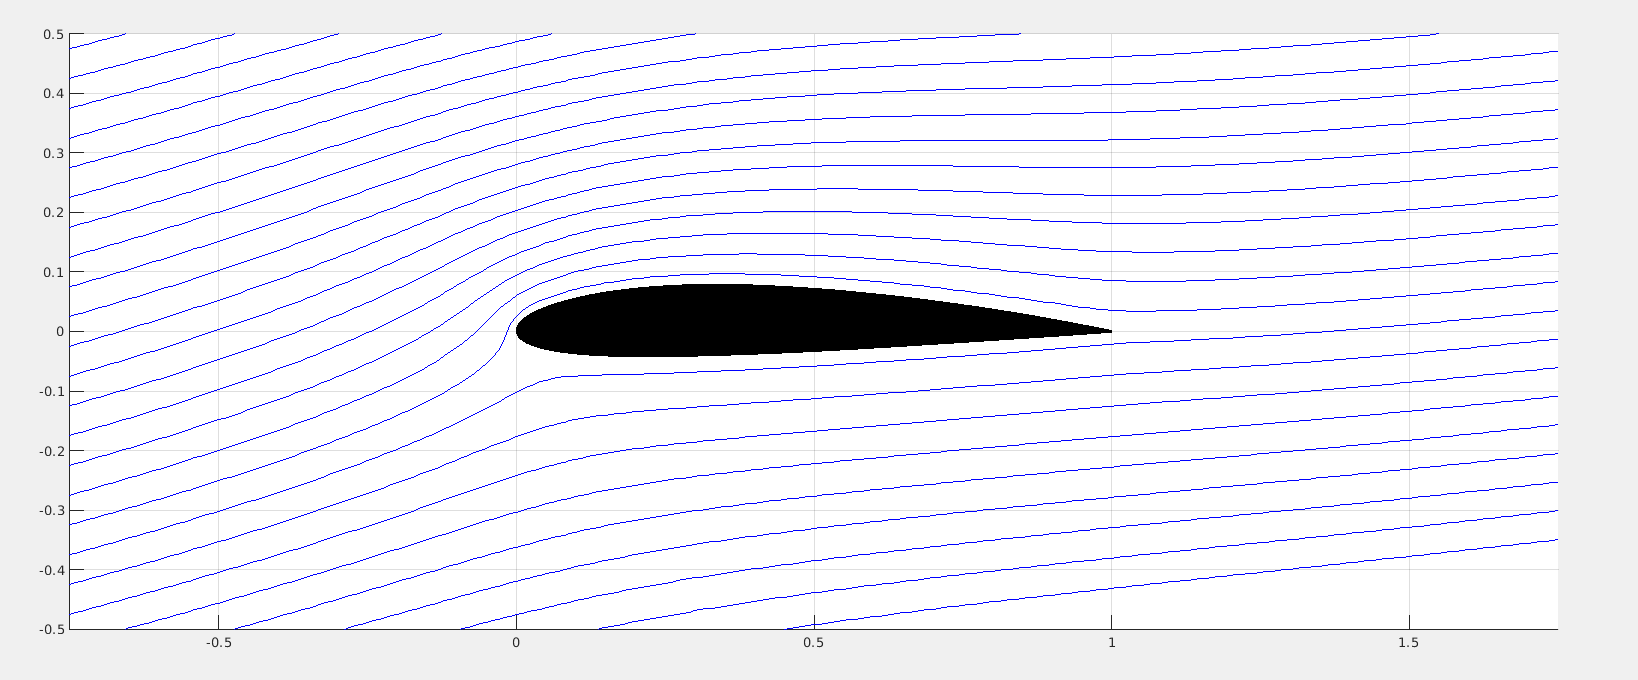
* Note, a steamline is essentially just the path a particle takes through the air in the case of a steady flow, which is what this problem depicts.

Pressure Coefficient Contour Plot: (Black means more negative, white means more positive)
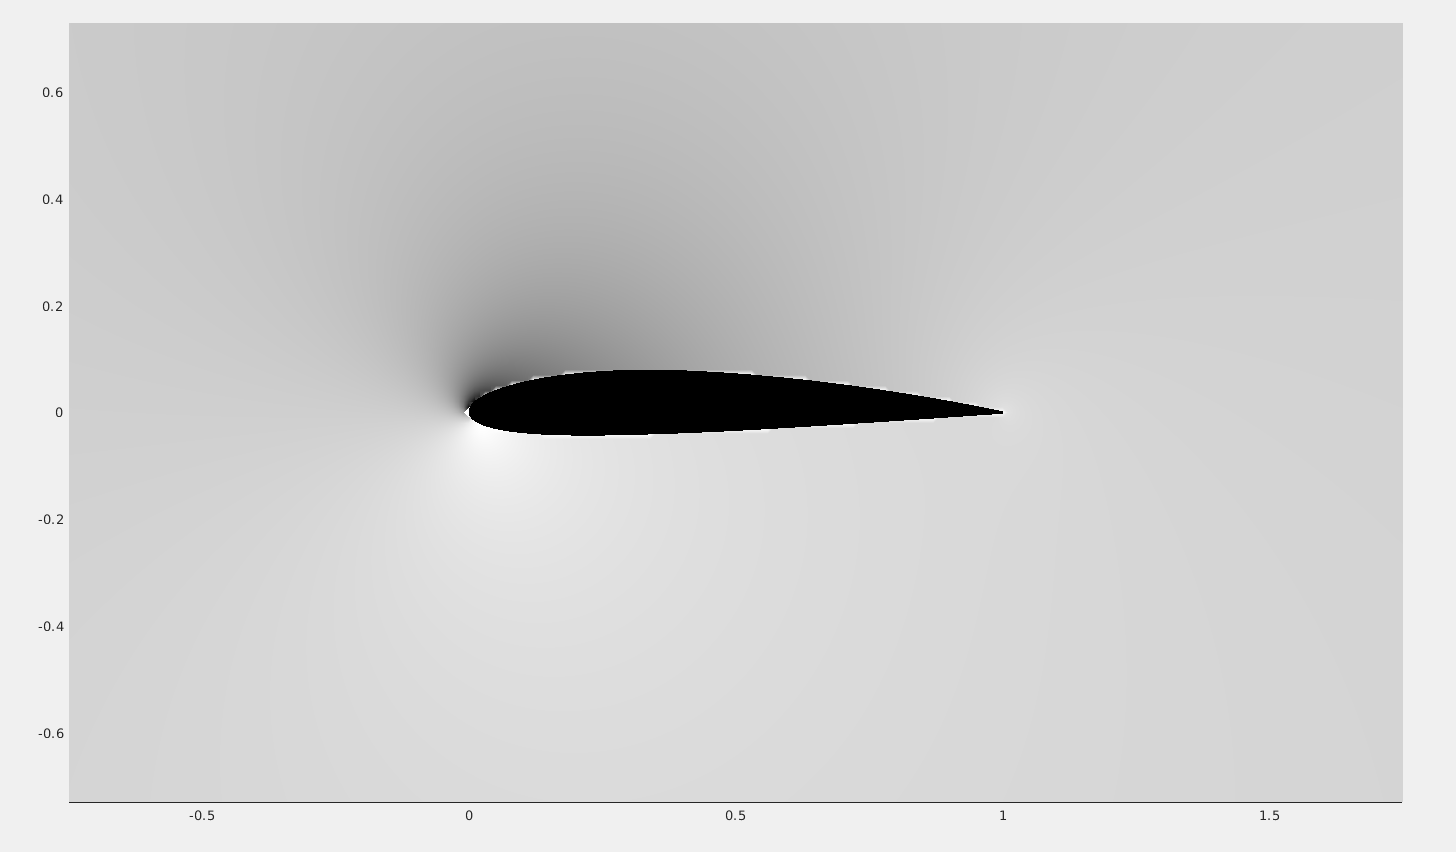